# (2) Notebook for bootstrapping samples and computing IT metrics

In [1]:
import pandas as pd
import sys
import os
import multiprocessing
import montreal_forced_aligner
import numpy as np
import ast
import engCDSutils as util
import importlib
from collections import Counter
import math
import matplotlib.pyplot as plt 
import seaborn as sns
from multiprocessing import Pool
import random
importlib.reload(util)

In [ ]:
# Replace the below links according to the file structure on your local computer

directory_with_corpora = 'infoTheoryProj/allTextInputs' #this link should contain all the corpora
directory_of_mfa =  'MFA/pretrained_models/dictionary' #this is the link to the MFA package that is installed on your computer
directory_of_csv = 'infoTheoryProj/dataScrape' #this is the link of the csv files with all the data
directory_of_output = 'infoTheoryProj/dictAlignment' #this is the link where the output will be stored
directory_of_g2p = 'MFA/pretrained_models/g2p' #this is the link to the MFA g2p folder that should have been automatically installed on your computer

The below cell contains a list of all the phonemes that the MFA package uses

In [2]:
all_mfa_phonemes = 'aj aw aː b bʲ c cʰ cʷ d dʒ dʲ d̪ ej f fʲ h i iː j k kʰ kʷ l m mʲ m̩ n n̩ ow p pʰ pʲ pʷ s t tʃ tʰ tʲ tʷ t̪ v vʲ w z æ ç ð ŋ ɐ ɑ ɑː ɒ ɒː ɔj ə ɚ ɛ ɝ ɟ ɟʷ ɡ ɡʷ ɪ ɫ ɫ̩ ɱ ɲ ɹ ɾ ɾʲ ɾ̃ ʃ ʉ ʉː ʊ ʎ ʒ ʔ θ'
all_mfa_phonemes =  all_mfa_phonemes.split(' ')

Note for readers: This notebook might sometimes refer to the agebins as inclusive (eg: 27-33) and sometimes as excluive (eg: 27-32). This has been made consistent in the manuscript, but for the code these must be treated as equivalent for labelling purposes.

In [3]:
subsetlist = []
def makeCombinedCorpora():
    for corpus in ['NewmanRatner','Brent','Rollins','Providence', 'Vankleeck']:
        subset, aggr = util.tokenDescriptions(directory_of_output,corpus)
        subset['corpus'] = corpus
        subsetlist.append(subset)
    
    big_df = pd.concat(subsetlist, ignore_index=True)
    return big_df

In [ ]:
giant_scrape = makeCombinedCorpora()
giant_scrape['age_bin']=pd.cut(giant_scrape['target_child_age'], [i for i in range(3,52,6)], right=False, labels=[str(i)+"-"+str(i+6) for i in range(3,47,6)],  include_lowest=False,   ordered=True)

Function to make sure that certain phones have been replaced

In [6]:
def engIPAFixes(df):
    '''
    Input : dataframe with phonemic glosses
    Fixes IPA errors caused by the english MFA models i.e. phoneme h, k, l 
    Collapsing secondary articulations into the base phoneme
    Getting rid of narrow transcriptions (i.e. allophonic variation in NAmEng phoneme inventory)
    '''
    
    replacement_dictionary = {"c":"k", 'cʰ':'k', 'cʷ':'k', 'ʎ':'l', 'ç':'h',  'aː':'a','iː':'i','ʉ':'u','ʉː':'u','ç':'h','bʲ':'b','dʲ':'d','d̪':'d','kʰ':'k','kʷ':'k','mʲ':'m', 'ɒː':'ɑ', 'ɑː':'ɑ', 'tʲ':'t', 'tʷ':'t', 't̪':'t' , 'tʰ':'t','ɟʷ':'g', 'ɡʷ':'ɡ', 'pʰ':'p', 'pʲ':'p', 'pʷ':'p','fʲ':'f', 'ɫ':'l','ɫ̩':'l̩','vʲ':'v','ɾʲ':'ɾ', 'ɾ̃':'ɾ', 'ɒ':'ɑ','ɲ':'n', 'ɱ':'n', 'ɐ':'ʌ', 'ɟ':'g'}
    
    
    series_new = []
    for entry in df['phonemic_gloss']:
        utterance_old = ast.literal_eval(entry)
        utterance_new = []
        for word in utterance_old:
            word_new = []
            for phoneme in word:
                try:
                    word_new.append(replacement_dictionary[phoneme])
                except:
                    word_new.append(phoneme)
            
            utterance_new.append(word_new)
        series_new.append(utterance_new)
    return series_new
    

In [7]:
ipa_fixed_giant_scrape = engIPAFixes(giant_scrape)
giant_scrape['phonemic_gloss_updated'] = ipa_fixed_giant_scrape

In [14]:
filepath_of_csv = None #insert here: the filepath of the csv file where you want to save the data
giant_scrape.to_csv(filepath_of_csv,index=False)

In [17]:
giant_scrape = pd.read_csv(filepath_of_csv)

A short example of how this data might be used:

In [73]:
from collections import Counter
sample1 = util.samplePhonemes(81000,  giant_scrape, '3-9')
wordlist1 = util.collectAllWords(sample1)
res = Counter(util.collectAllPhonemes(wordlist1))
contexts_from_sample = util.getContexts(sample1) 

In [41]:
util.getPredic('ɫ', ['pʰ', 'ʊ'],contexts_from_sample)

1.0

In [106]:
util.getInfor ('ʃ',  contexts_from_sample)

5.103420370769848

## Determining sample size for bootstrapping

In [6]:
N_sizes = [i for i in range(3000,300000,3000)]
agebins = [str(i)+"-"+str(i+6) for i in range(3,47,6)]

In [ ]:
link_to_samplingResults = None #link to folder where the sampling results are stored

In [120]:
util.getSuccessiveSamples(link_to_samplingResults)
overall_df = pd.read_csv(os.path.join(link_to_samplingResults, 'mean_results.csv'))

In [39]:
overall_df

,Unnamed: 0,sample_size,age_bin,mean_informativity,mean_logfreq
0,0,3000,3-9,3.400721,6.775276
1,1,6000,3-9,3.464587,6.919997
2,2,9000,3-9,3.546936,7.039518
3,3,12000,3-9,3.558302,7.032979
4,4,15000,3-9,3.572426,7.042721
...,...,...,...,...,...
259,259,87000,45-51,3.818582,7.251621
260,260,90000,45-51,3.819642,7.251882
261,261,93000,45-51,3.823028,7.254002
262,262,96000,45-51,3.821966,7.254077


In [9]:
def process_sample(input_tuple):
    
    ''' 
    input_tuple is a tuple consisting of (sample_size, age_bin, full_giant_scrape)

    This function performs all the IT metrics calculation on the sample and saves the results in a csv file
    '''
    
    N = input_tuple[0]
    agebin = input_tuple[1]
    giant_scrape = input_tuple[2]
    
    sample = util.samplePhonemes(N, giant_scrape, agebin)
    contexts_from_sample = util.getContexts(sample)
    list_of_phonemes_in_sample = list(contexts_from_sample.keys())
    freq_results = util.getLogFreq(sample)
    
    freq_values = []
    info_values = []
    
    for phoneme in list_of_phonemes_in_sample:
        freq_values.append(freq_results[phoneme])
        info_values.append(util.getInfor(phoneme, contexts_from_sample))
        
    name_of_file = "sample" + str(N) + "age" + agebin
    df_result = pd.DataFrame({'phoneme': list_of_phonemes_in_sample, 'logfreq': freq_values, 'informativity': info_values})
    df_result.to_csv(os.path.join(link_to_samplingResults, name_of_file + '.csv'))
    
    
def collectResults(directory):
    mean_logfreq = []
    mean_infor = []
    df_N = []
    df_age = []
    
    for agebin in agebins:
        for N in N_sizes:
            csv_to_look_for = 'sample'+str(N)+'age'+agebin+'.csv'
            df_result = pd.read_csv(os.path.join(directory, csv_to_look_for))
            
            mean_logfreq.append(df_result['logfreq'].mean())
            mean_infor.append(df_result['informativity'].mean())
            df_N.append(N)
            df_age.append(agebin)
            
    mean_result = pd.DataFrame({'sample_size': df_N, 'age_bin':df_age,  'mean_informativity':mean_infor, 'mean_logfreq':mean_logfreq})
    mean_result.to_csv(os.path.join(directory,  'mean_results.csv'))
 

In [30]:
tuples = [(N,agebin, giant_scrape) for N in N_sizes for agebin in agebins]    

def pool_handler():
    p = Pool(100)
    p.map(process_sample, tuples)

In [31]:
%%time
pool_handler()

CPU times: user 9min 13s, sys: 1min 38s, total: 10min 52s
Wall time: 1h 20min 36s


In [32]:
collectResults(link_to_samplingResults)

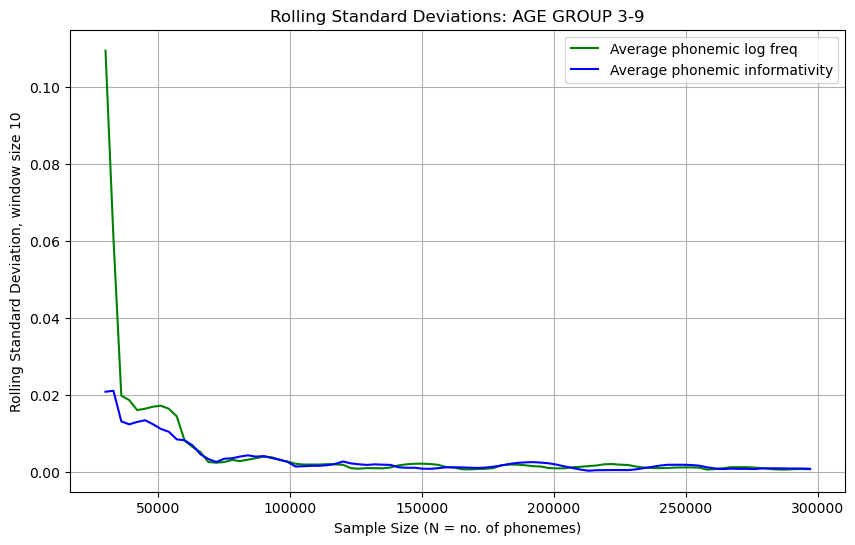

The first time the rolling std for logfreq falls below 0.01 is 19    60000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 18    57000
Name: sample_size, dtype: int64


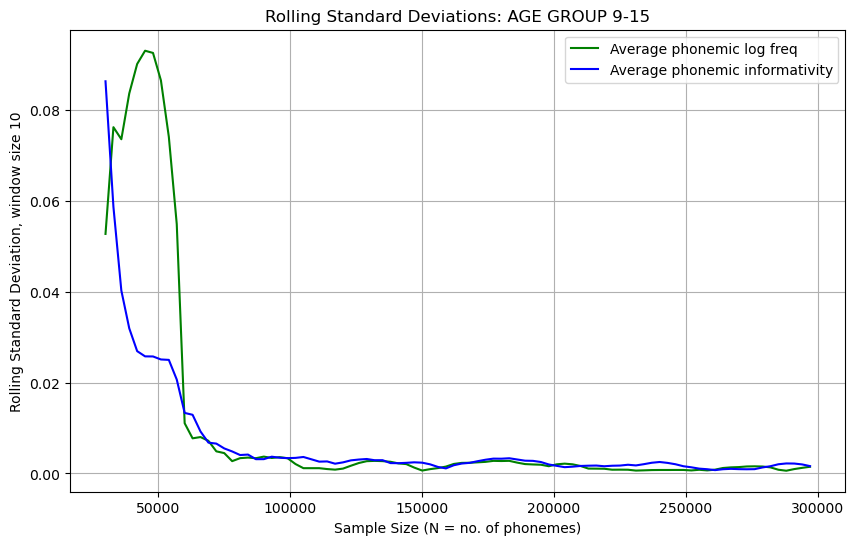

The first time the rolling std for logfreq falls below 0.01 is 119    63000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 120    66000
Name: sample_size, dtype: int64


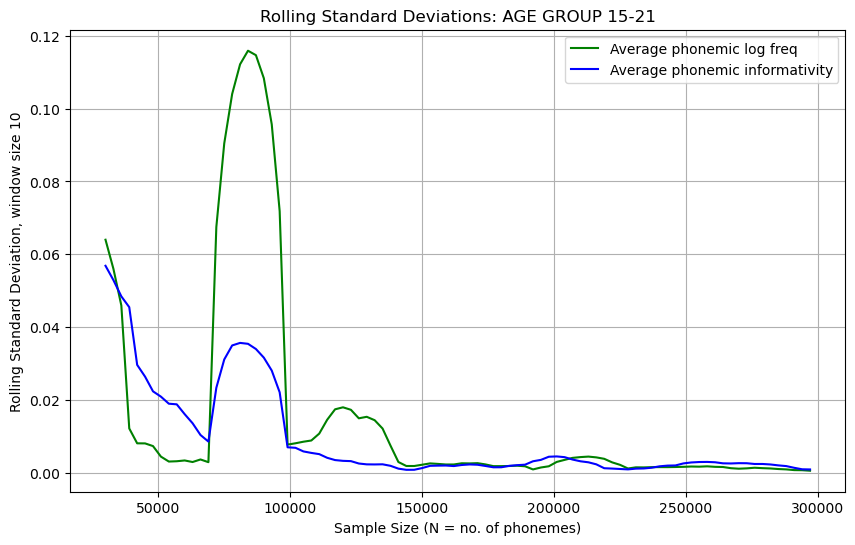

The first time the rolling std for logfreq falls below 0.01 is 211    42000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 220    69000
Name: sample_size, dtype: int64


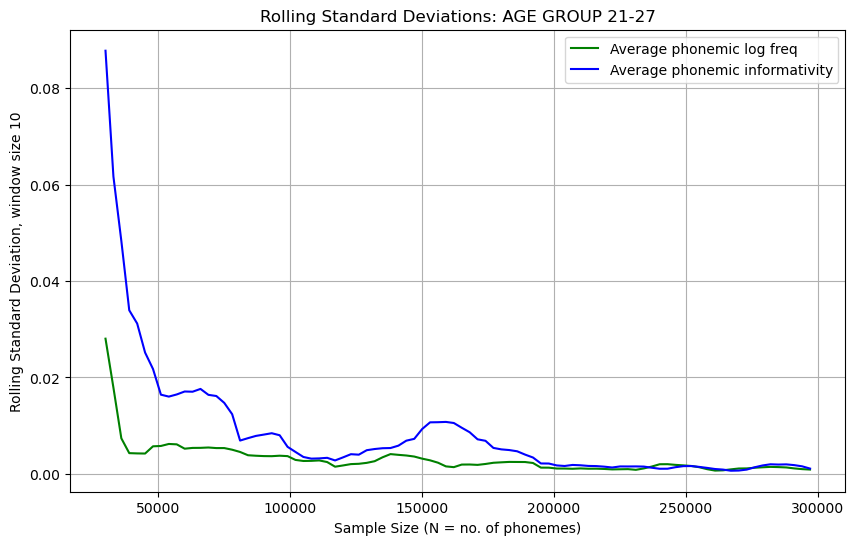

The first time the rolling std for logfreq falls below 0.01 is 308    36000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 323    81000
Name: sample_size, dtype: int64


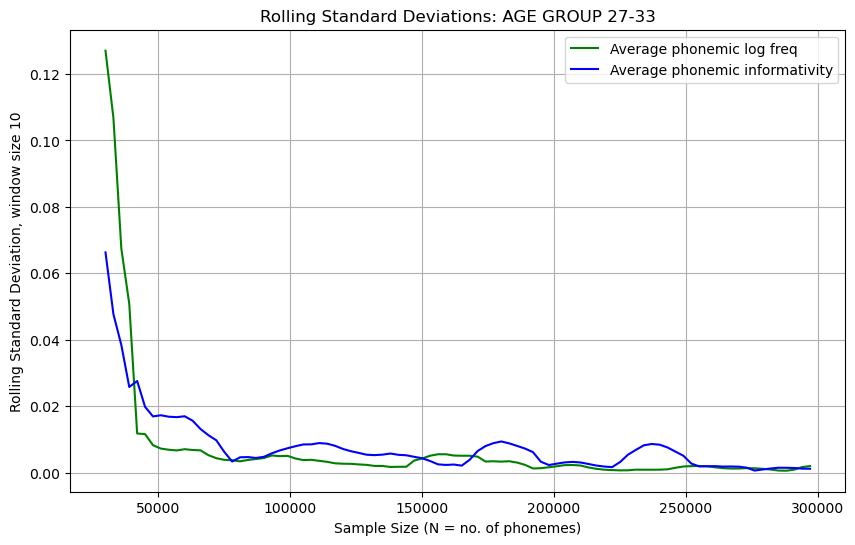

The first time the rolling std for logfreq falls below 0.01 is 411    48000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 419    72000
Name: sample_size, dtype: int64


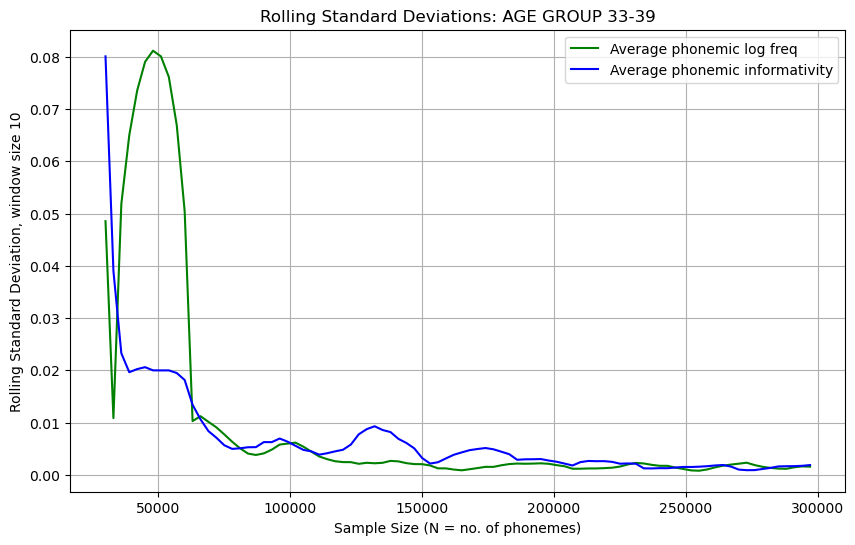

The first time the rolling std for logfreq falls below 0.01 is 518    72000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 517    69000
Name: sample_size, dtype: int64


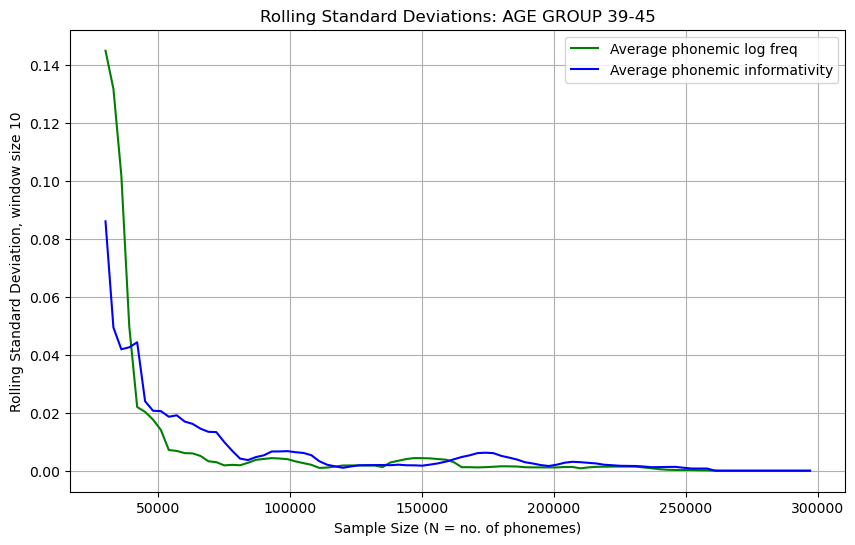

The first time the rolling std for logfreq falls below 0.01 is 611    54000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 618    75000
Name: sample_size, dtype: int64


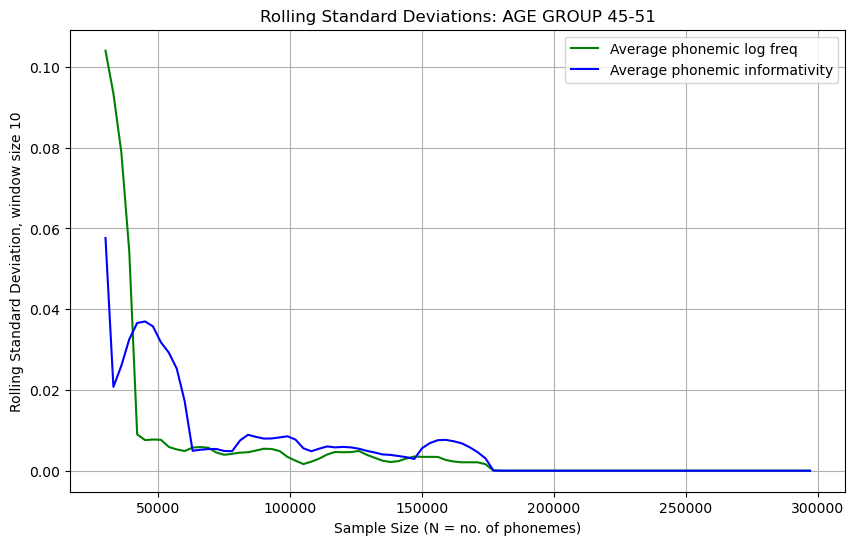

The first time the rolling std for logfreq falls below 0.01 is 706    42000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 713    63000
Name: sample_size, dtype: int64


In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

util.createSampleSizePlot(10, os.path.join(directory,  'mean_results.csv'))

/tmp/ipykernel_5149/2873539111.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df_subset['rolling_std_infor'] = overall_df_subset.mean_informativity.rolling(windowsize).std()
/tmp/ipykernel_5149/2873539111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df_subset['rolling_std_logfreq'] = overall_df_subset.mean_logfreq.rolling(windowsize).std()


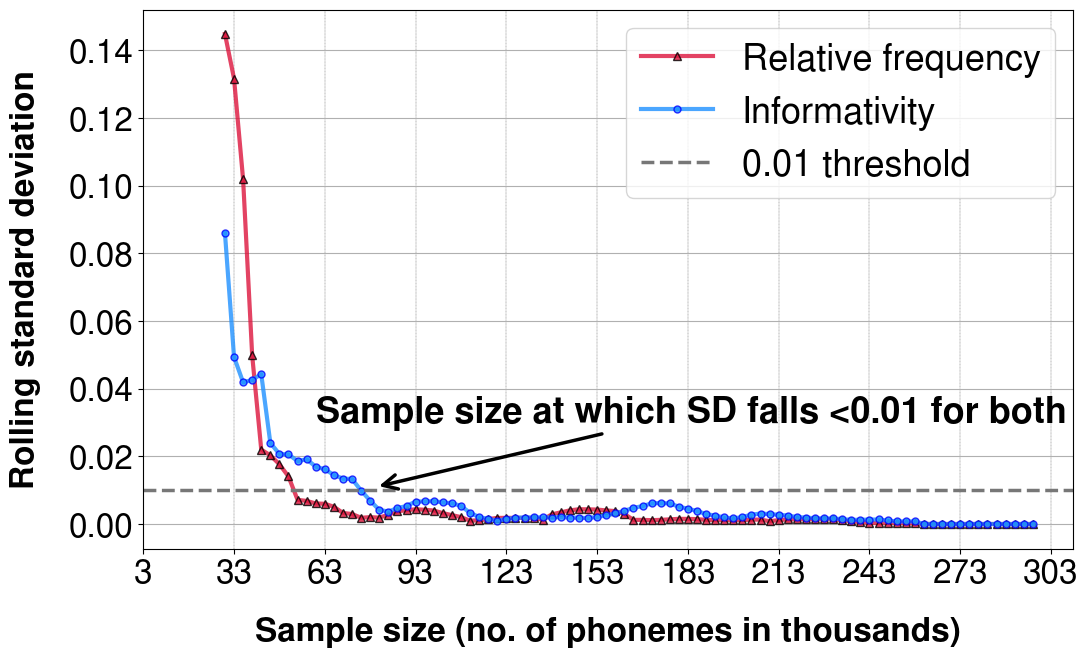

The first time the rolling std for logfreq falls below 0.01 is 611    54000
Name: sample_size, dtype: int64
The first time the rolling std for informativity falls below 0.01 is 618    75000
Name: sample_size, dtype: int64


In [13]:
## Plot for 1

from matplotlib.ticker import FuncFormatter

def thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

def createSampleSizePlotOne(windowsize:int, link_to_mean_csv,age):
    agebins = [str(i)+"-"+str(i+6) for i in range(3,47,6)]
    overall_df = pd.read_csv(link_to_mean_csv)
    
    overall_df_subset = overall_df[overall_df['age_bin'] == age]
    overall_df_subset['rolling_std_infor'] = overall_df_subset.mean_informativity.rolling(windowsize).std()
    overall_df_subset['rolling_std_logfreq'] = overall_df_subset.mean_logfreq.rolling(windowsize).std()
    with plt.rc_context({
        'font.size': 26,        # General font size
        'axes.titlesize': 20,   # Font size for the title
        'axes.labelsize': 24,   # Font size for x and y labels
        'xtick.labelsize': 24,  # Font size for x-axis tick labels
        'ytick.labelsize': 24,  # Font size for y-axis tick labels
        'font.family': 'Nimbus Sans'  # Font family
    }):
         

        plt.figure(figsize=(12,7))

        plt.plot(overall_df_subset['sample_size'], overall_df_subset['rolling_std_logfreq'], color="#DC143C", label='Relative frequency',linewidth=3,linestyle='solid',marker='^',markersize=6,alpha=0.8,markerfacecolor='#DC143C',mec='black')
        plt.plot(overall_df_subset['sample_size'], overall_df_subset['rolling_std_infor'], color="#1E90FF", label='Informativity',linewidth=3,linestyle='solid',marker='o',markersize=5,alpha=0.8,markerfacecolor="#1E90FF",mec='blue')

        plt.xlabel('Sample size (no. of phonemes in thousands)', fontweight="bold",labelpad=20)
        plt.ylabel('Rolling standard deviation', fontweight="bold",labelpad=20)
        grid_positions = np.arange(9000, 300001, 9000)
        tick_positions = np.arange(3000, 300001, 60000)
        
        plt.grid(True, which='both', axis='x', linestyle='--', color='black', linewidth=0.2)
        plt.axhline(y=0.01, color='#777777', linestyle='dashed', linewidth=2.5,label='0.01 threshold')
        plt.yticks(np.arange(0,0.15,0.02))
        plt.xticks(np.arange(3000,303001,30000))
        plt.legend()
        plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands))
        plt.annotate('Sample size at which SD falls <0.01 for both', fontweight='bold',xy=(80000, 0.011), xytext=(60000, 0.03), arrowprops=dict(facecolor='black', arrowstyle='->',lw=2.5))
        plt.grid(True)
        plt.savefig('stab_crit.pdf', format='pdf',bbox_inches='tight')
        plt.show()

    print('The first time the rolling std for logfreq falls below 0.01 is' ,overall_df_subset[overall_df_subset['rolling_std_logfreq']<0.01]['sample_size'].head(1))
    print('The first time the rolling std for informativity falls below 0.01 is' ,overall_df_subset[overall_df_subset['rolling_std_infor']<0.01]['sample_size'].head(1))
    
    
createSampleSizePlotOne(10, os.path.join(directory,  'mean_results.csv'),'39-45')

## Using the sample size (determined above) we can now compute our I.T. metrics

In [ ]:
linkToComputeAfterSamplingFolder = None #insert here

In [ ]:
def computeMetricsByAge(input_tuple):
        '''
        Given a sample size (determined earlier), age group and full data, this function creates a csv that has each phoneme found in
        the sample, alongwith its log frequency and informativity values
        
        '''
        N = input_tuple[0]
        age = input_tuple[1]
        giant_scrape = input_tuple[2]
        age_specific_sample = util.samplePhonemes(N, giant_scrape, age)
        contexts_from_sample = util.getContexts(age_specific_sample)
        list_of_phonemes_in_sample = list(contexts_from_sample.keys())
        freq_results = util.getLogFreq(age_specific_sample)
            
        freq_values = []
        info_values = []
    
        for phoneme in list_of_phonemes_in_sample:
            freq_values.append(freq_results[phoneme])
            info_values.append(util.getInfor(phoneme, contexts_from_sample))
        
        name_of_file = "sample" + str(N) + "age" + age
        df_result = pd.DataFrame({'phoneme': list_of_phonemes_in_sample, 'logfreq': freq_values, 'informativity': info_values})
        df_result.to_csv(os.path.join(linkToComputeAfterSamplingFolder, name_of_file + '.csv'))

In [73]:
agebins = [str(i)+"-"+str(i+6) for i in range(3,47,6)]    
tuples = [(81000, agebin, giant_scrape)  for agebin in agebins  ]    
def pool_handler():
    p = Pool(20)
    p.map(computeMetricsByAge, tuples)

In [83]:
%%time
pool_handler()

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 18.6 μs


In [23]:
def createMetricPlots(directory, prefix, metric):
    
    mean_logfreq = []
    mean_infor = []
    df_age = []
    
    agebins = [str(i)+"-"+str(i+6) for i in range(3,47,6)]   
    for age in agebins:
        filename = prefix + "age"+age+".csv"
        df_result = pd.read_csv(os.path.join(directory,filename))
        
        mean_logfreq.append(df_result['logfreq'].mean())
        mean_infor.append(df_result['informativity'].mean())
        df_age.append(age )
            
    mean_result = pd.DataFrame({ 'age_bin':df_age,  'mean_informativity':mean_infor, 'mean_logfreq':mean_logfreq})
   
    
    plt.figure(figsize=(10, 6))
    if metric == 'informativity':
        plt.plot(mean_result['age_bin'], mean_result['mean_informativity'], color='blue', label='Average phonemic informativity')
    else:
        
        plt.plot(mean_result['age_bin'], mean_result['mean_logfreq'], color='green', label='Average phonemic log freq')
    
    plt.title('Age-wise information-theoretic metrics')
    plt.xlabel('Age group')
    plt.ylabel('Mean value')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    return mean_result

In [22]:
def combinePhonemically(directory,prefix):
    agebins = [str(i)+"-"+str(i+6) for i in range(3,47,6)]   
    dflist = []
    
    for age in agebins:
        filename = prefix + "age"+age+".csv"
        df_result = pd.read_csv(os.path.join(directory,filename), index_col=0)
        df_result['age'] = age
        dflist.append(df_result)
        
    a = pd.concat(dflist,axis=0)
    return a

In [89]:
concat_results = combinePhonemically(linkToComputeAfterSamplingFolder,'sample81000')

In [91]:
melted = pd.melt(concat_results, id_vars=['phoneme','age'], value_vars=['logfreq', 'informativity'])
logfreq_melted = melted[melted['variable']=='logfreq']
info_melted = melted[melted['variable']=='informativity']
logfreq_melted['phoneme'] = logfreq_melted['phoneme'].astype('category')
info_melted['phoneme'] = info_melted['phoneme'].astype('category')

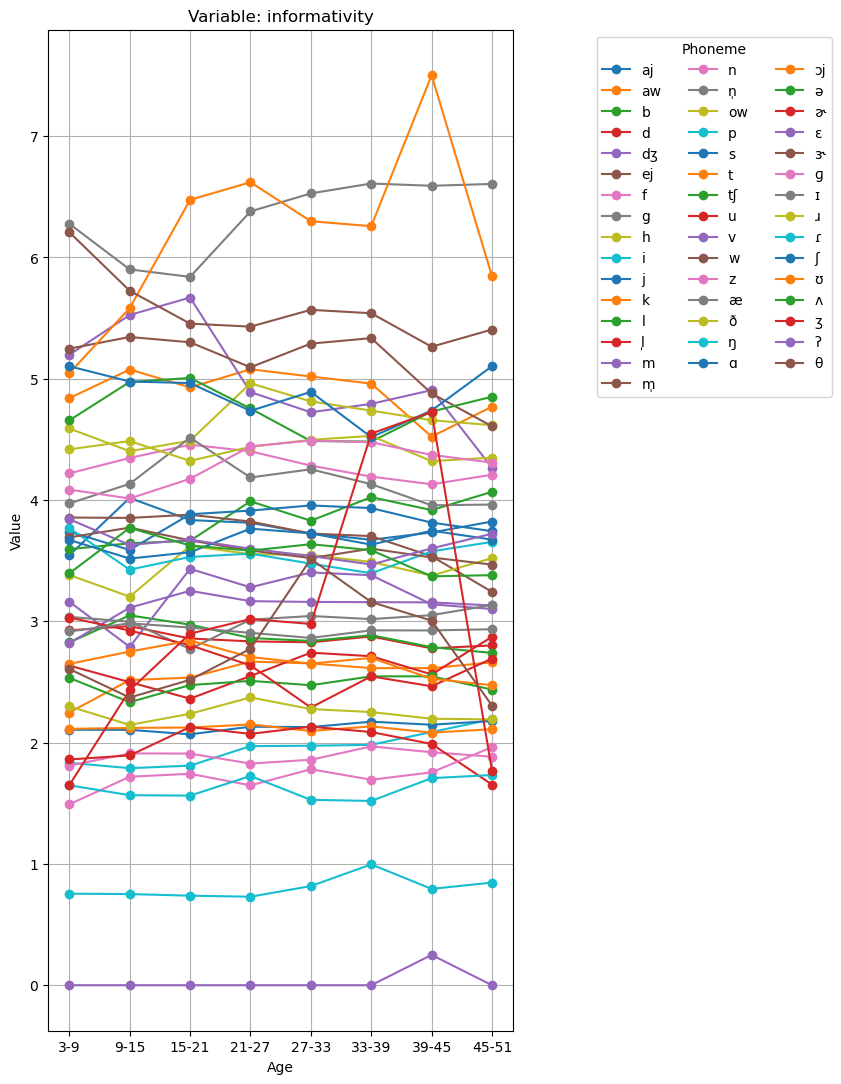

In [92]:
util.linePlots('informativity',logfreq_melted,info_melted)

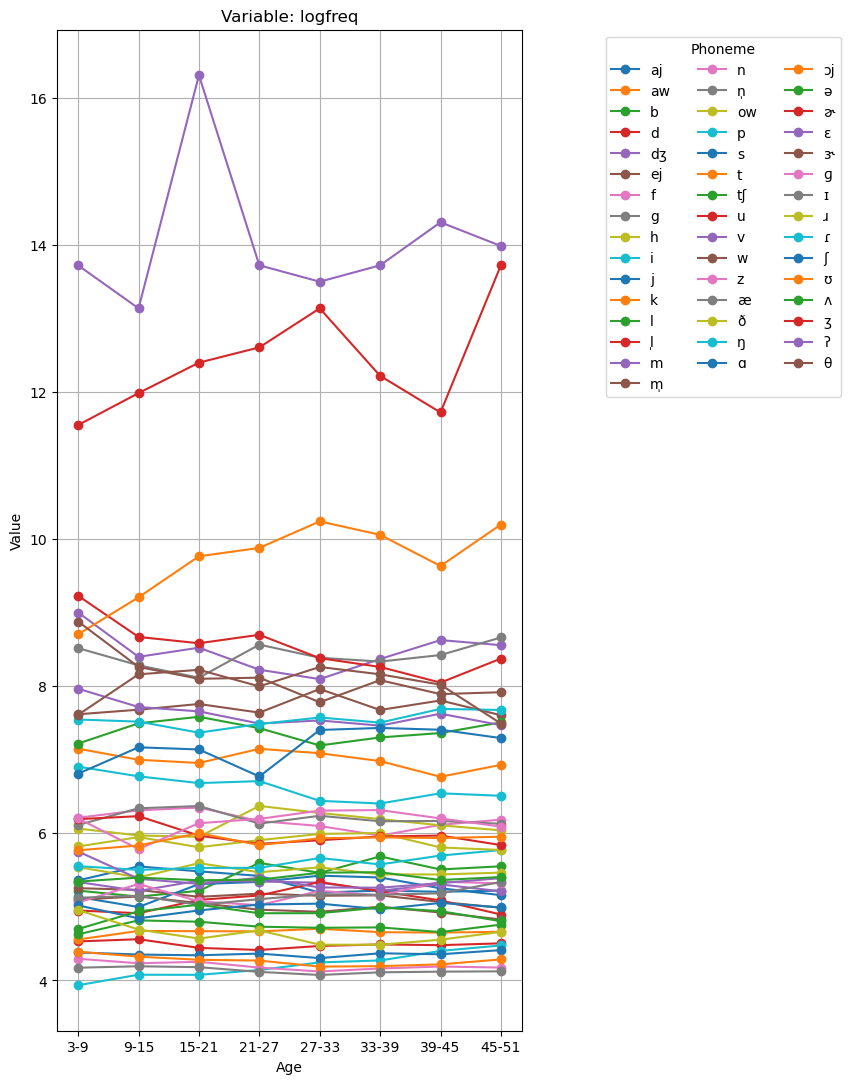

In [93]:
util.linePlots('logfreq',logfreq_melted,info_melted)

In [134]:
concat_results.to_csv('concat_results.csv',index=False)

## Correcting for outlier samples from our bootstrapping by resampling

In [ ]:
linkToCorrectionsDirectory = None # insert here

In [47]:
def correctBootstrap(input_tuple):

    '''
        This function does the resampling for us, which is necessary for dealing with outlier samples
    '''
    
    size_per_sample=input_tuple[0]
    index_no=input_tuple[1]
    giant_scrape = input_tuple[2]
    age = input_tuple[3]

    
    ages = []
    sample_no = []
    sample_index = []
    mean_infor = []
    mean_logfreq = []
    seed = int(index_no)*100
    how_many_samples = 100
    
    
    age_specific_sample = util.samplePhonemes(size_per_sample, giant_scrape, age, seed)
    contexts_from_sample = util.getContexts(age_specific_sample)
    list_of_phonemes_in_sample = list(contexts_from_sample.keys())
    freq_results = util.getLogFreq(age_specific_sample)

    freq_values = []
    info_values = []

    for phoneme in list_of_phonemes_in_sample:
        freq_values.append(freq_results[phoneme])
        info_values.append(util.getInfor(phoneme, contexts_from_sample))

    phoneme_df = pd.DataFrame({
                'phoneme': list_of_phonemes_in_sample,
                'freq_values': freq_values,
                'info_values': info_values})
    sampled_df_phoneme_name = 'sample_'+str(index_no)+'_age_' +str(age)+'_phonemic.csv'
    phoneme_df.to_csv(os.path.join(linkToCorrectionsDirectory,sampled_df_phoneme_name),index=False)
    ages.append(age)
    sample_index.append(index_no)
    sample_no.append(how_many_samples)
    mean_logfreq.append(np.mean(freq_values)) 
    mean_infor.append(np.mean(info_values)) 
    
    sampled_df_name = 'sample_'+str(index_no)+'_age_' +str(age)+'.csv'
    age_specific_sample.to_csv(os.path.join(linkToCorrectionsDirectory,sampled_df_name),index=False)
     

In [23]:
tuples = [(81000,100,giant_scrape,age)  for age in agebins]
results = []


def save_result(result):
    results.append(result)


In [26]:
# This dictionary was obtained by using the outlier detection code from the dataAnalysis notebook 

missing_samples = {'age':{0: '15-21',
                              1: '21-27',
                              2: '27-33',
                              3: '3-9',
                              4: '33-39',
                              5: '39-45',
                              6: '45-51',
                              7: '9-15'},
                       
        'missing_indices': {0: [0, 15, 30],
                            1: [31],
                            2: [59, 70, 83],
                            3: [14, 93],
                            4: [11, 25, 26, 29, 45, 84, 92, 97],
                            5: [7, 24, 36, 47, 76, 78, 96, 97],
                            6: [16, 24, 37, 65],
                            7: [24, 35, 78, 91]}}

In [29]:
tuples_corrections = []
for i in range(8):
    for s in missing_samples['missing_indices'][i]:
        tuples_corrections.append((81000, s ,giant_scrape,missing_samples['age'][i]))

In [32]:
results = []
tuples = [(81000, 100,giant_scrape,age) for age in agebins]
        
def pool_handler_corrections():
    with Pool(30) as p:
        
        for result in p.imap_unordered(correctBootstrap, tuples_corrections):
            results.append(result)  

In [ ]:
%%time
pool_handler_imap()

In [ ]:
%%time
pool_handler_corrections()

## Using the newly sampled samples to replace older ones

In [58]:
import glob
oldpath = None # insert link to earlier bootstrap results
newpath = linkToCorrectionsDirectory  # link to the corrected samples
new_files = os.listdir(newpath)

In [ ]:
linkTo81kSamples = None #insert link to the folder with all the samples

In [63]:
how_many_samples = 100

def replaceSamples():

    '''
        This function replaces the old samples with the new samples that have been corrected
    '''
    
    for age in agebins:
        sample_index = []
        ages = []
        mean_logfreq=[]
        mean_infor=[]
        sample_nos=[]
        for index_no in range(how_many_samples):
            csv_to_look_for =  'sample_'+str(index_no)+'_age_' +str(age)+'_phonemic.csv'
            if csv_to_look_for in new_files:
                phoneme_df = pd.read_csv(os.path.join(newpath,csv_to_look_for))
            else:
                phoneme_df = pd.read_csv(os.path.join(oldpath,csv_to_look_for))

            freq_values = phoneme_df['freq_values']
            info_values = phoneme_df['info_values']

            ages.append(age)
            sample_index.append(index_no)
            sample_nos.append(how_many_samples)
            mean_logfreq.append(np.mean(freq_values)) 
            mean_infor.append(np.mean(info_values)) 
            
        df = pd.DataFrame({
        'ages': ages,
        'sample_no': sample_nos,
        'sample_index': sample_index,
        'mean_infor': mean_infor,
        'mean_logfreq': mean_logfreq}) 

        name_of_csv = 'results_'+str(how_many_samples)+'_age_' +str(age)+'.csv'
        df.to_csv(os.path.join(linkTo81kSamples,name_of_csv ),index=False)

        

In [64]:
replaceSamples()

## Reading in the 100 bootstrapped samples of size 81k phonemes for each agebin

In [65]:
directory_bootstrap = linkTo81kSamples
agebins = [str(i)+"-"+str(i+6) for i in range(3,47,6)]
bootstrapped_avg_infor = []
bootstrapped_avg_logfreq = []
df_list = []

for age in agebins:
    csv_path = os.path.join(directory_bootstrap,'results_100_age_'+age+'.csv')
    df = pd.read_csv(csv_path)
    df_list.append(df)
    infor_avg = df['mean_infor'].mean()
    logfreq_avg = df['mean_logfreq'].mean()
     
    bootstrapped_avg_infor.append(infor_avg)
    bootstrapped_avg_logfreq.append(logfreq_avg)

summary_boot = pd.DataFrame({
    'age': agebins,
    'mean_infor': bootstrapped_avg_infor,
    'mean_logfreq': bootstrapped_avg_logfreq}) 

all_bootstrapped = pd.concat(df_list)
all_bootstrapped.to_csv("all_bootstrapped_v3.csv",index=False)

In [66]:
summary_boot

,age,mean_infor,mean_logfreq
0,3-9,3.267794,6.282432
1,9-15,3.328025,6.280439
2,15-21,3.381677,6.284198
3,21-27,3.411519,6.294178
4,27-33,3.430500,6.293764
5,33-39,3.394741,6.297448
6,39-45,3.391060,6.276505
7,45-51,3.293765,6.323917


In [87]:
summary_boot.to_csv('summary_boot_v2.csv',index=False)

In [32]:
age_midpoints = [i+3 for i in range(3,47,6)]

In [33]:
age_midpoints

[6, 12, 18, 24, 30, 36, 42, 48]

In [34]:
age_mapping={}
for i in range(len(agebins)):
    age_mapping[agebins[i]] = age_midpoints[i]

In [36]:
all_bootstrapped['age_numeric'] = all_bootstrapped['ages'].map(age_mapping)

In [38]:
all_bootstrapped

,ages,sample_no,sample_index,mean_infor,mean_logfreq
0,3-9,100,0,7.820973,5.270702
1,3-9,100,1,7.819535,5.269064
2,3-9,100,2,7.843164,5.293405
3,3-9,100,3,7.806224,5.256379
4,3-9,100,4,7.803766,5.253636
...,...,...,...,...,...
95,45-51,100,95,7.841783,5.291009
96,45-51,100,96,7.849404,5.299066
97,45-51,100,97,7.839236,5.287135
98,45-51,100,98,7.833961,5.282600


In [54]:
all_bootstrapped.to_csv('all_bootstrapped.csv',index=False)